# Instructions
- From the __File__ menu, __Save a copy in Drive__. otherwise you will not be able to edit it

---
- From the __Runtime__ menu,  click on __Change runtime type__ . Here in __Hardware accelerator__ choose __GPU__ and __SAVE__

---
- To run a __Single Cell__ __ctrl + enter__
- To run  __all cells:ctrl + F9__
- To run  __all cells after:ctrl + F10__
- To run  __all cells before:ctrl + F8__
---

- run the __cell below__  (with the line __pip install -I --no-cache-dir pillow__). Go to __Runtime__ menu and __Restart runtime__
- After restarting, you can run all the cells

In [1]:
PLATFORM = 'colab'
if PLATFORM == 'colab':
    !pip install -I --no-cache-dir pillow
    pass
else:
    pass

     |████████████████████████████████| 2.1MB 9.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [2]:
PLATFORM = 'colab'
if PLATFORM == 'colab':
    !pip install --upgrade git+https://github.com/rusty1s/pytorch_geometric.git
    !pip install torch_sparse
    !pip install torch_scatter
    !pip install torch_cluster
    pass
else:
    pass

  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-l7j7t3f8
  Running command git clone -q https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-l7j7t3f8
     |████████████████████████████████| 348kB 9.1MB/s 
     |████████████████████████████████| 51kB 11.8MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-szkvohxh/wheels/ab/87/fc/b4c9a3f883596ad9928293e7a69e0b229a1eb35dc400b10b2b
  Stored in directory: /root/.cache/pip/wheels/91/3e/ee/e5630ef0fd53cedaa6e911ba27e8b40fff034388d1f264bb92
Successfully built torch-geometric plyfile
  Stored in directory: /root/.cache/pip/wheels/9d/83/0a/38ea460df5586a075b877fe089619e5238487712a0645940bd
Successfully built torch-sparse
  Stored in directory: /root/.cache/pip/wheels/7f/21/0b/c42fa9353ceec5e87464599e470a03e4250ec667b4a392fa7d
Successfully built torch-scatter
     |████████████████████████████████| 716kB 9.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/ee/54/4a/eb079ec61377a93ea07aba9eea

# Graph Neural Networks (GNNs)

In this lab we will implement a Graph Neural Networks for a semi-supervised task. We will begin by reviewing the basics of Graph Neural Network and later on will try to implement Graph Convolutional Network for classifying node in a graph citation network (CiteSeer) task using [`pytorch_geometric`](https://pytorch-geometric.readthedocs.io/en/latest/).  We will also see unsupervised node embeddings using GNNs.

### Basics of GNNs

**Setup**:

Assume we have a graph $G = (N,E)$ consisting of a set of nodes/vertices $N$ and edges $E$. We represent this graph as an adjacency matrix $A \in \mathbb{R}^{N \times N}$, which can be binary or real valued (unweighted or weighted graph). The graph can be directed (which means that $A$ will be symmetric), or undirected ($A$ will not be symmetric). Each vertex (node) of the graph can also have features. We denote $X \in \mathbb{R}^{m \times N}$ a matrix of node features (i.e. each node has a $\mathbb{R}^m$ dimensional feature vector associated with it. Examples of features associated with a node can be categorical attributes, text, image data, node degrees, indicator vectors, etc.

In this notebook, we will assume an undirected, unweighted graph.


**From Neural Networks to Graph Neural Networks via Computational Graphs**:

*Computational Graphs*: A computational graph is a way of representing math functions in the language of graph theory. Consider an equation $f(x,y,z) = (x + y) * z$. We can represent this as the following computational graph:

<img src="https://drive.google.com/uc?id=17v9jb5MKkcurkyzkl-Hck4TybxGqYzGz" width="300">

*Neural Networks as Computational Graphs*: When we define the architecture of a neural network we’re laying out the series of sub-functions and specifying how they should be composed. We can see this concretely below:

<img src="https://drive.google.com/uc?id=15JUulxYc7Zx3gnWWWMXL_PoxxIv_ZxFC" width="600"> 

*Graph Neural Networks*: We saw what computation graphs are and how a standard neural network can be viewed as one. What about the GNNs? Consider the graph below. For the traget node `A`, we can generate its embedding based on the local neighborhoods. In general, the nodes can *aggregate* information from their neighbors using neural networks. Note that every node defines a unique computational graph. <img src="https://drive.google.com/uc?id=1bxPuUnUnNEeadH5mGL-ppB_GM4fiaYU1" width="1000"> 

We observe that the nodes have embeddings at each layer, and the model can have arbitrary depth. Also, by convention, `layer 0` embedding of a node $u$ is its input feature $x_u$. Taking cue from the neural network computation graph above, we can now begin to open the black boxes of GNN, as shown below.

<img src="https://drive.google.com/uc?id=1cPw8lBEdAc2zYFVmhynbe16oycu9cTwW" width="1000">

*A basic approach to GNN - the math*: Average neigbor messages and apply a neural network. <img src="https://drive.google.com/uc?id=1CauumcxZ-l2Sf_4ehjY-u23cdF1EGuO9" width="500">

These operations can be efficiently implemented using sparse batch operations. The equations for them are below:
$$ H^{(k)} = \sigma \left( D^{\frac{1}{2}} \hat{A} D^{ \frac{1}{2} } H^{(k-1)} W_{k} \right)$$
where for the identity matrix $I$, $$ \hat{A} = A + I $$
and $D$ is the diagonal node degree matrix of $\hat{A}$, $$D_{ii} = \sum_{j} A_{i,j}$$

The key distinctions among different variation of GNNs are in how different approaches aggregates these messages. We now can compute the embeddings for each node in the graph. For example, these node embeddings can be a latent representation of the node or can be an output class in case of node classification problems. Given the output embeddings, we can compute the loss function and update the neural network using gradient descent. 

<img src="https://drive.google.com/uc?id=1NItrLHizYfRqQiW9n1H-zLl_1yB896GE" width="500">

## Transductive learning using Graph Neural Networks

In this task, we need to identify *groups* in a social network. We consider the problem of [Zachary's karate club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). It is based on a small social network of 34 persons in  a Karate club. In this club, there exists two faction of people, and the task is to identify which faction each person belongs to based on their interactions with other members.

**Problem Setting**:

Given a social network graph and association of few people to a particular faction, identify the faction of each of the members in the social network.

### Imports

In [0]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm

# for reproducibility
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Utility functions

In [0]:
def get_numpy_dataset(dataset):
    ''' 
    input: object of `pytorch_geometric` dataset class
    output: convert the following info to numpy
    x: node features
    y: node class label
    edge: defines the connection between the source node and the
          target node. It has a form [[source nodes][target nodes]]
          and is of 2xnb_nodes dimensions
    A: Adjacency matrix
    '''
    
    edge,x,y = dataset[0]
    numpy_x = x[1].numpy()
    numpy_y = y[1].numpy()
    numpy_edge = edge[1].numpy()

    nb_nodes = len(numpy_x)

    # Create adjacency matrix
    A = np.zeros((nb_nodes, nb_nodes))
    A[numpy_edge[0], numpy_edge[1]] = 1
    
    return(numpy_x, numpy_y, numpy_edge, A)


def plot_graph(X, Y, edge, train_mask):
    '''
    helper function to visualize the input graph
    '''
    
    # define color scheme
    color_array = []
    if train_mask is None:
        color_array = np.where(Y==0, 'blue', 'green')
    else:
        for i in range(len(train_mask)):    # unlabelled
            if train_mask[i] and Y[i] == 0:
                color_array.append('blue')
            elif train_mask[i] and Y[i] == 1:
                color_array.append('green')
            else:
                color_array.append('gray')
    
    # define graph
    g = nx.Graph(X)

    src = edge[0]
    dst = edge[1]
    edgelist = zip(src, dst)

    for i,j in edgelist:
      g.add_edge(i,j) 

    # plot graph
    nx.draw_networkx(g, node_color=color_array, with_labels=True)

### Compute diagonal node degree matrix $D$ and $\hat{A}$.

In [0]:
def preprocess(A):
    '''
    Computes the diagonal node degree matrix $D$ 
    and $\hat{A}$ for given an adjacency matrix $A$
    '''
    
    # Get size of the adjacency matrix
    size = len(A)
    # Get the degrees for each node
    degrees = []
    for node_adjaceny in A:
        num = 0
        for node in node_adjaceny:
            if node == 1.0:
                num = num + 1
        # Add an extra for the "self loop"
        num = num + 1
        degrees.append(num)
    # Create diagonal matrix D from the degrees of the nodes
    D = np.diag(degrees)
    # Cholesky decomposition of D
    D = np.linalg.cholesky(D)
    # Inverse of the Cholesky decomposition of D
    D = np.linalg.inv(D)
    # Create an identity matrix of size x size
    I = np.eye(size)
    # Turn adjacency matrix into a numpy matrix
    A = np.matrix(A)
    # Create A hat
    A_hat = A + I
    # Return A_hat
    return A_hat, D

### Data loading, preprocessing, and visualization

Note: As the nodes don't have any node features, we choose the node features $X = I$, i.e.the node indicator vectors of the node index. 

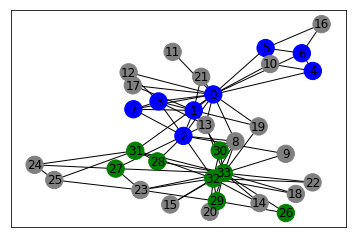

In [6]:
from torch_geometric.datasets import KarateClub

X, Y, edge, A = get_numpy_dataset(KarateClub())

# for transductive setting, mask labels for certain nodes
train_mask = np.zeros(len(Y), dtype=bool)
val_mask = np.zeros(len(Y), dtype=bool)
train_mask[:8] = True
train_mask[-8:] = True

plot_graph(X, Y, edge, train_mask)
plt.show()

A_hat, D = preprocess(A)

In [0]:
def gcn(W1, W2, W3, X, A_hat, D):
    '''
    Computes $z = \sigma (D^{1/2}\hat{A}D^{1/2} X W)$
    '''
    # Forward pass
    hidden_layer_1 = torch.tanh(D.mm(A_hat).mm(D).mm(X).mm(W1))
    hidden_layer_2 = torch.tanh(D.mm(A_hat).mm(D).mm(hidden_layer_1).mm(W2))
    Y_pred = torch.sigmoid(D.mm(A_hat).mm(D).mm(hidden_layer_2).mm(W3))
    return Y_pred, hidden_layer_2

In [8]:
# Convert input to torch tensor
X_ = torch.from_numpy(X).float()
Y_ = torch.from_numpy(Y).float()
A_hat_ = torch.from_numpy(A_hat).float()
D_ = torch.from_numpy(D).float()
train_mask_ = torch.from_numpy(train_mask)


# Define learnable parameters
W1 = torch.FloatTensor(np.random.randn(34,4)).requires_grad_()
W2 = torch.FloatTensor(np.random.randn(4,2)).requires_grad_()
W3 = torch.FloatTensor(np.random.randn(2,1)).requires_grad_()

#define optimizers
optimizer = torch.optim.SGD([W1, W2, W3], lr=1e-3)

# Loss
criterion = torch.nn.BCELoss()
learning_rate = 1e-3
# for book keeping
loss_accumulate = []

# training loop
for t in tqdm(range(2500)):
    # Forward pass
    Y_pred, Z_ = gcn(W1, W2, W3, X_, A_hat_, D_)
    Y_pred = Y_pred.squeeze()

    # zero the gradients before updating weights (if any)
    optimizer.zero_grad()
    
    # Compute loss
    loss = criterion(Y_pred[train_mask], Y_[train_mask])
    loss_accumulate.append(loss.item())

    # Backpropagation
    loss.backward()

    # Update weights using gradient descent
    optimizer.step()
       
    

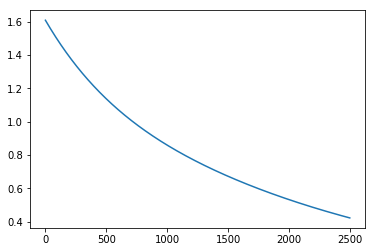

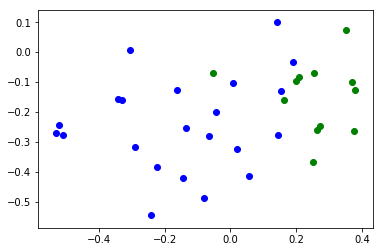

In [9]:
# Plot loss
plt.plot(loss_accumulate)
plt.show()

# Plot learned embeddings
# hidden_layer_2 has a dimension of 2, we visualize those here
Z = Z_.detach().numpy()
Y_pred_ = np.squeeze(np.where(Y_pred > 0.5, 1, 0))
color_array = np.where(Y_pred_==0, 'blue', 'green')
for i in range(len(Z)):
  [x, y] = Z[i]
  clr = color_array[i]
  plt.scatter(x,y, color=clr)

Predictions: [0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1]
Ground Truth [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Overall accuracy: 0.7941176470588235


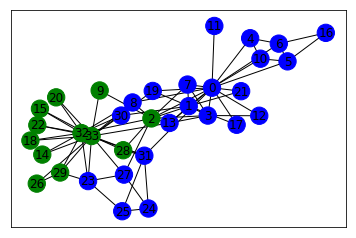

In [10]:
# infer predictions
Y_pred_ = np.squeeze(np.where(Y_pred > 0.5, 1, 0))
print('Predictions:', Y_pred_)
print('Ground Truth', Y)

# compute accuracy
correct = 0
for i in range(len(Y)):
    if Y[i] == Y_pred_[i]:
        correct += 1 
acc = correct/len(Y)
print('Overall accuracy:', acc)

# plot inferred graph labels
plot_graph(X, Y_pred_, edge, None)
plt.show()

## Visualize Embeddings for the entire graph in 2D

Here, we show that a untrained GCN can also be used to compute embeddings of the nodes. We define a GNN which takes in input for the 34 nodes and outputs the embeddings in 2D space for us to visualize.

<img src="https://drive.google.com/uc?id=1XmL_0tL9ms22QGXsQPtuAa2ZU-IhXQxd" width="500">

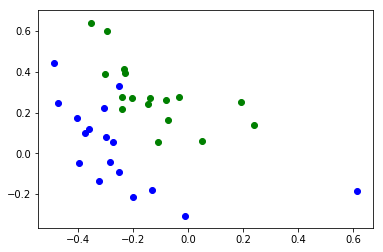

In [11]:
def gcn_emb(W1, W2, W3, X, A_hat, D):
    '''
    Computes $z = \sigma (D^{1/2}\hat{A}D^{1/2} X W)$
    '''
    # Forward pass
    hidden_layer_1 = torch.tanh(D.mm(A_hat).mm(D).mm(X).mm(W1))
    hidden_layer_2 = torch.tanh(D.mm(A_hat).mm(D).mm(hidden_layer_1).mm(W2))
    Y_pred = torch.tanh(D.mm(A_hat).mm(D).mm(hidden_layer_2).mm(W3))
    return Y_pred
  
 
# Convert input to torch tensor
X_ = torch.from_numpy(X).float()
Y_ = torch.from_numpy(Y).float()
A_hat_ = torch.from_numpy(A_hat).float()
D_ = torch.from_numpy(D).float()

# Define learnable parameters
W1 = torch.FloatTensor(np.random.randn(34,4)).requires_grad_()
W2 = torch.FloatTensor(np.random.randn(4,4)).requires_grad_()
W3 = torch.FloatTensor(np.random.randn(4,2)).requires_grad_()

Z_ = gcn_emb(W1, W2, W3, X_, A_hat_, D_).squeeze()
Z = Z_.detach().numpy()
color_array = np.where(Y==0, 'blue', 'green')
for i in range(len(Z)):
  [x, y] = Z[i]
  clr = color_array[i]
  plt.scatter(x,y, color=clr)



## Transductive Supervised Learning using PyTorch Geometric

We saw how to implement a GNN for a simple task. We will now see an example of classifying nodes in a large scale graph citation network (CiteSeer) using [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/).

An academic citation network is one where the research papers are treated as nodes of a graph and they are linked with each other depending on the citations. CiteSeer data set consisits of bag of words representation of documents and citation links between the documents. There are a total of 3703 papers each of which can belong to one of the six sub-areas. Our task is that given the classes of a few papers, can we infer classes of all other nodes using the citation network.

### Imports, data loader and data statistics

In [12]:
# Imports
import os.path as osp
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv

# Dataset definition
dataset = 'CiteSeer' #'Cora', 'PubMed'
path = osp.join('..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

# Dataset statistics
print(data)
print('Number of nodes:', data.x.size()[0])
print('Dimension of each node features:', dataset.num_features)
print('Number of classes in the data set:', dataset.num_classes)
print('Number of nodes in the training set:', torch.sum(data.train_mask).item())
print('Number of nodes in the validation set:', torch.sum(data.val_mask).item())
print('Number of nodes in the test set:', torch.sum(data.test_mask).item())

Processing...
Done!
Data(edge_index=[2, 9104], test_mask=[3327], train_mask=[3327], val_mask=[3327], x=[3327, 3703], y=[3327])
Number of nodes: 3327
Dimension of each node features: 3703
Number of classes in the data set: 6
Number of nodes in the training set: 120
Number of nodes in the validation set: 500
Number of nodes in the test set: 1000


### Define a Graph Convolutional Network

In [0]:
# Define the network
class Net(torch.nn.Module):
    def __init__(self,in_features,num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_features, 16, cached=True)
        self.conv2 = GCNConv(16, num_classes, cached=True)

    def forward(self,x,edge_index):
            # get the graph data
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


# Put everything on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features,dataset.num_classes).to(device)
data = data.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

### Write the training and the validation/test loop

In [0]:
# Training function
def train():
    # train mode
    model.train()
    
    # zero the gradients before updating the parameters (if any)
    optimizer.zero_grad()
    
    # forward pass
    prediction = model(data.x, data.edge_index)
    
    # loss computation
    loss = F.nll_loss(prediction[data.train_mask], data.y[data.train_mask])
    # backprop
    loss.backward()
    # perform parameters updates using Adam optimizer
    optimizer.step()

# Test and validation loop
def test():
    # eval mode
    model.eval()
    
    # forward pass and compute accuracy
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


### Run the training

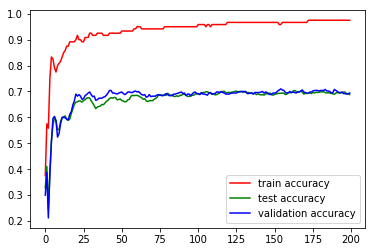

In [15]:
# Book keeping
trends = {'train_accuracy':[],
          'test_accuracy':[],
          'validation_accuracy':[],
         }

# Training and validation loop
best_val_acc = test_acc = 0
for epoch in tqdm(range(1, 201)):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    
    trends['test_accuracy'].append(tmp_test_acc)
    trends['train_accuracy'].append(train_acc)
    trends['validation_accuracy'].append(val_acc)
    
# Plot training, validation and test accuracy
plt.figure()
plt.plot(trends['train_accuracy'],color='r',label='train accuracy')
plt.plot(trends['test_accuracy'],color='g',label='test accuracy')
plt.plot(trends['validation_accuracy'],color='b',label='validation accuracy')
plt.legend()
plt.show()


### Excercise

Try running GCNs for the `Cora` and `PubMed` data set and visualize the training, validation and test accuracy. Also, try visualizing the hidden layer outputs using T-SNE